In [1]:
from models import *
from epmt_job import setup_orm_db
import fnmatch

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = [15, 8]

import numpy as np
import pandas as pd

import settings
settings.db_params["host"] = "db"
setup_orm_db()


{'provider': 'postgres', 'user': 'postgres', 'password': 'example', 'host': 'localhost', 'dbname': 'EPMT'}


In [9]:


def barplot(labels=[], y_val=[], mn="None", yscale="log", title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    plt.bar(index, y_val)
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn)
    plt.title(mn+' '+title_suffix)
    plt.show()

def barplot_stack(labels=[], y_val=[], y2_val=[], mn=[], yscale="log", ylim=(), title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    p1 = plt.bar(index, y_val, color='r')
    p2 = plt.bar(index, y2_val, bottom=y_val, color='g')
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn[0]+"+"+mn[1])
    plt.legend((p1[0], p2[0]), (mn[0], mn[1]))
    plt.title(mn[0]+"+"+mn[1]+' '+title_suffix)
    plt.ylim(ylim)
    plt.show()



In [18]:
def get_job_list():
    q = select(j for j in Job)
    return q[:]
    
# Return list of objects for jobid

def get_processes_job(jobid):
    # lookup job
    try:
        j = Job[jobid]
    except Exception as e:
        print("not found",e)
        return None
    print("Found job",jobid,"with",len(j.processes),"processes and",len(j.processes.threads),"threads")
    return j.processes
    
# Reduce all processes by executable name and return sums of metric

    # we could do this with a query, maybe
    # processes=select((p.exename, sum(p.duration), count(p)) for p in Process if p.job == j).order_by(-2)
    #    for p in processes:
    #        threads += p.threads

def get_job_processes_reduce_attr(jobid, attr_name, cutoff=0.0, exelen=10):
    processes = get_processes_job(jobid)
    if not processes:
        return
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen]
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename]["count"] = 1
            proc_dict[exename]["threads"] = len(p.threads)
            proc_dict[exename][attr_name] = getattr(p, attr_name)
        else:
            proc_dict[exename]["count"] += 1
            proc_dict[exename]["threads"] += len(p.threads)
            proc_dict[exename][attr_name] += getattr(p, attr_name)
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in list(proc_dict):
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

# Reduce all processes by executable name and return sums of metric

def get_job_processes_full_attr(processes, attr_name, cutoff=0.0, exelen=10):
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen] 
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename][attr_name] = [getattr(p, attr_name)]
            proc_dict[exename]["start"] = [getattr(p, "start")]                     
        else:
            proc_dict[exename][attr_name].append(getattr(p, attr_name))
            proc_dict[exename]["start"].append(getattr(p, "start"))
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in proc_dict.keys():
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

In [19]:
js = get_job_list()
for j in js:
    print(j.jobid,"from",j.start,"to",j.end,"by",j.user.name,"took",j.duration/1e6,"s.")
    if j.ppr:
        print("\t","Post-processing run, job.name:",j.jobname)
        print("\t","Post-processing run, ppr.component:",j.ppr.component)
        print("\t","Post-processing run, ppr.name:",j.ppr.name)
        print("\t","Post-processing run, ppr.jobname:",j.ppr.jobname)
        print("\t","Post-processing run, ppr.oname:",j.ppr.oname)


20345339.moab01.princeton.rdhpcs.noaa.gov from 2019-02-20 19:58:41.274267 to 2019-02-20 22:13:23.131187 by Jeffrey.Durachta took 8081.85692 s.
	 Post-processing run, job.name: CM4_piControl_C_atmos_00050101
	 Post-processing run, ppr.component: atmos
	 Post-processing run, ppr.name: CM4_piControl_C
	 Post-processing run, ppr.jobname: CM4_piControl_C_atmos_00050101
	 Post-processing run, ppr.oname: 00050101
20348693.moab01.princeton.rdhpcs.noaa.gov from 2019-02-21 04:41:56.433031 to 2019-02-21 06:55:04.301253 by Jeffrey.Durachta took 7987.868222 s.
	 Post-processing run, job.name: CM4_piControl_C_atmos_00100101
	 Post-processing run, ppr.component: atmos
	 Post-processing run, ppr.name: CM4_piControl_C
	 Post-processing run, ppr.jobname: CM4_piControl_C_atmos_00100101
	 Post-processing run, ppr.oname: 00100101
20349536.moab01.princeton.rdhpcs.noaa.gov from 2019-02-21 08:22:11.444810 to 2019-02-21 10:57:04.634468 by Jeffrey.Durachta took 9293.189658 s.
	 Post-processing run, job.name: CM

Found job 20345339.moab01.princeton.rdhpcs.noaa.gov with 37464 processes and 42314 threads


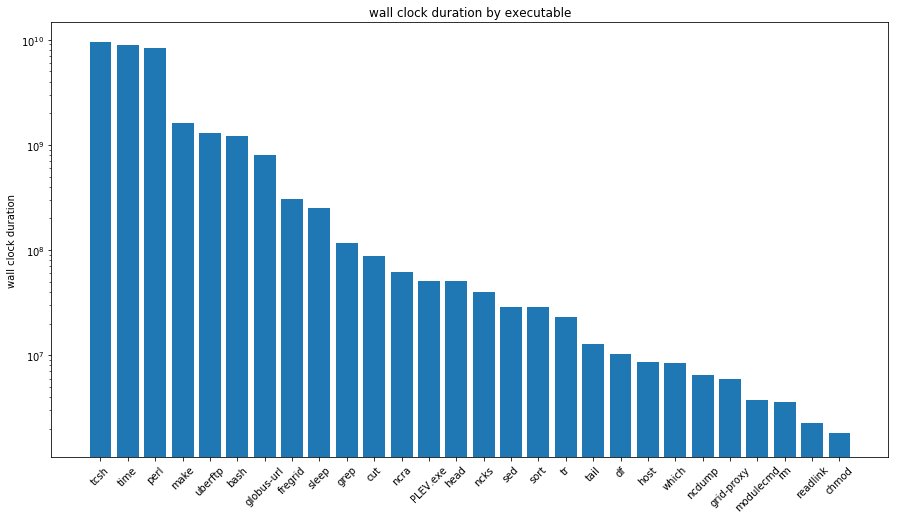

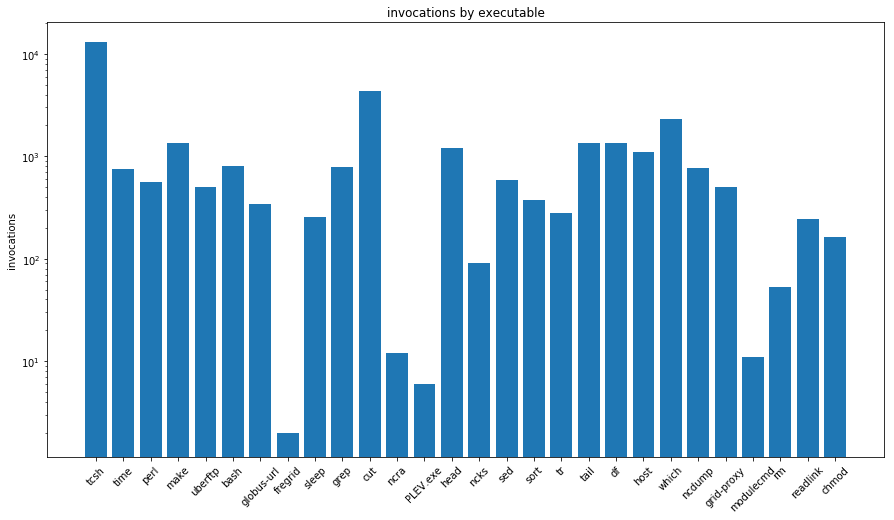

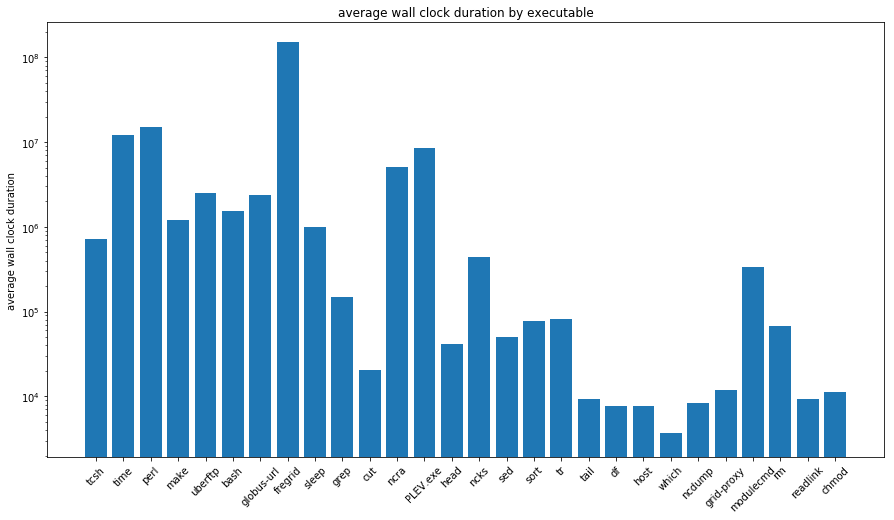

In [20]:
j = js[0].jobid
total, proc_dict = get_job_processes_reduce_attr(jobid=j, attr_name='duration', cutoff=1000000.0)
labels = []
y_val = []
y_val2 = []
y_val3 = []
labels = sorted(proc_dict.keys())
labels = sorted(proc_dict, key=lambda k: (proc_dict[k]["duration"]), reverse=True)
for k in labels:
    value = proc_dict[k]
    y_val3.append(value["duration"]/value["count"])
    y_val.append(value["duration"])
    y_val2.append(value["count"])
    
barplot(labels=labels,y_val=y_val,mn="wall clock duration")
barplot(labels=labels,y_val=y_val2,mn="invocations")
barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")



In [21]:
# Return list of objects for jobid

def get_processes_job_filter(jobid, pat=None):
    query = select ((p.exename, p.start, p.duration) for p in Process 
                    if p.job in select(j for j in Job if j.jobid == jobid)).order_by(2)
    if pat:
        query = query.filter(lambda p, q, r: p.startswith(pat))
    return query[:]

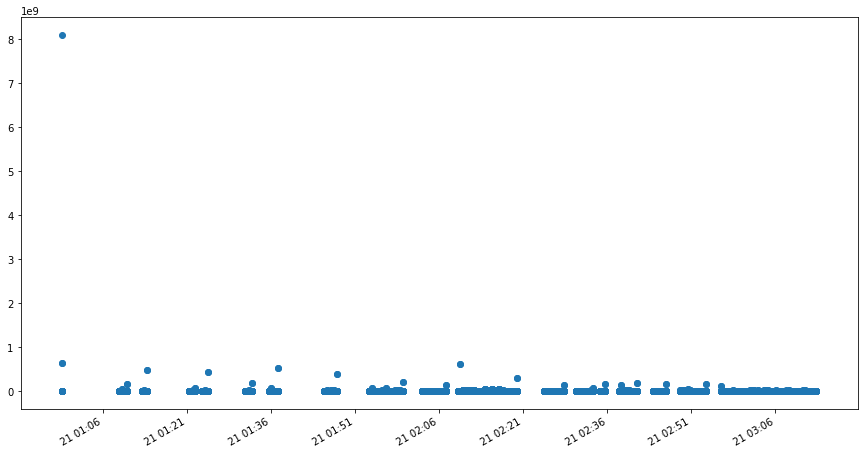

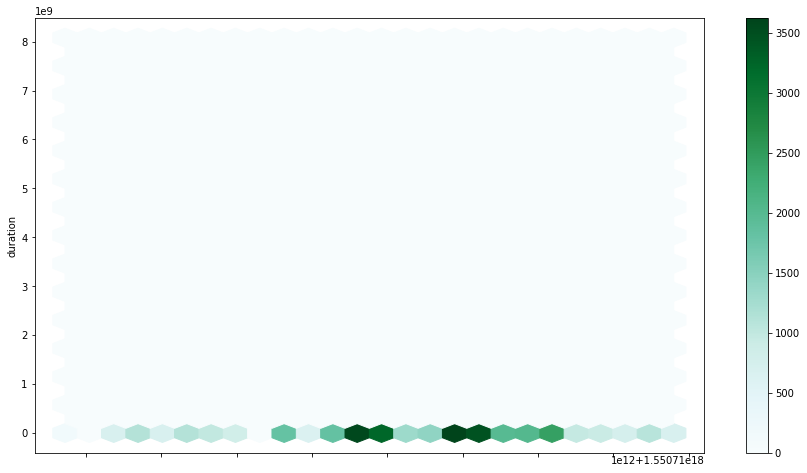

In [31]:
a = get_processes_job_filter(jobid=j)    
#print(a)
e,t,d = zip(*a)
plt.plot([],[])
plt.scatter(t,d)
plt.gcf().autofmt_xdate()
plt.show()

df = pd.DataFrame( { 'time': t, 'duration': d })
df['time'] = pd.to_numeric(df['time'])
df.plot.hexbin(x='time', y='duration', gridsize=25)

#    value["duration"]
    #y_val.append()
#    print value["start"]
    #x_val.append(value["start"])

#x_val = [i for i in range(len(y_val))]
#print x_val, len(y_val)
##barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")
#barplot(labels=labels,y_val=y_val,mn="wall clock duration")
#barplot(labels=labels,y_val=y_val2,mn="invocations")

In [32]:
def compute_quantiles(frame):
    retval = frame.quantile([.5,.999])
    return retval

def get_outliers(pdf, metric):
    frame_quantiles = compute_quantiles(pdf[metric])
    return pdf[pdf[metric] > frame_quantiles[.999]]

def print_outliers(d, metric):
    if len(d.index):
        print("\t",len(d.index),"outliers in metric",metric,"mean",d[metric].describe()["mean"]) 
    for index, row in d.iterrows():
        thr = row['thread']
        proc = thr.process
        print("\t",thr,proc,proc.exename+"("+str(proc.pid)+") at",proc.start,metric,row[metric])
        
def remove_outliers(dfi, dfol):
#    print len(dfi),list(dfi)
#    print len(dfol),list(dfol)
    dfi = dfi[~dfi.thread.isin(dfol.thread)]
#    print len(dfi)
    return dfi




In [39]:
tofind = [ "delayacct_blkio_time","usertime","invol_ctxsw","time_oncpu","time_waiting","systemtime" ]

def get_df_all_process(jids,exe):
    q = Process.select(lambda p: p.job in jids and p.exename==exe).without_distinct()
#    print "exe",exe,"ran",len(q),"times"
    q = select(p.threads.metrics for p in q).without_distinct()
# order by is important as it always produces the same order of threads
    q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# make lists
    meas = {}
    for m in q[:]:
        if m[1] not in meas:
            meas[m[1]] = [ (m[0], m[2]) ]
        else:
            meas[m[1]].append( (m[0], m[2]) )
# make df
    df = pd.DataFrame()
    for k in tofind:
        if k in meas:
            v,t = zip(*meas[k])
            df[k] = v
            if 'thread' not in df.columns:
                df['thread'] = t
    return df

def get_filter_criteria(by_jids):
# First compute averages of filter/reference jobs
    q1 = Process.select(lambda p: p.job in by_jids).without_distinct()
    q1 = select(p.exename for p in q1).order_by(1) #.without_distinct()
    criteria = {}
    for exe in q1[:]:
        df = get_df_all_process(by_jids,exe)
        print(exe,len(df))
        outlier_dfs=[]
        outlier_procs=[]
        for metric in tofind:
            b = get_outliers(df[['thread',metric]].copy(),metric)
            #print_outliers(b,metric)
            outlier_dfs.append(b)
            for index, row in b.iterrows():
                outlier_procs.append(row['thread'].process)
                #, metric))
        #print "Processes with more than one outlier"
        #procs,metrics = zip(*outlier_procs)
        procs = outlier_procs
        dfvc = pd.DataFrame({'thread': procs})
        vc = dfvc['thread'].value_counts()
        vc = vc[ vc != 1]
        for index, value in vc.iteritems():
#            print index,index.exename,"on",index.host.name,"at",index.start,"for",index.duration
#        if len(vc):
#            vc.plot.bar(subplots=True,title=index.exename+" processes with > 1 outlier",color=['darkblue'])
#            plt.show()
# FIX:      We should record which outlier(s) for each process!
            pass
        newdf = df
        for d in outlier_dfs:
            newdf = remove_outliers(newdf,d)
#        print df.describe()
        criteria[exe] = newdf.describe()
    return criteria
#
# If we get here, we now have, by executable, a set of criteria to filter the input jobs
#
def filter_jobs(jids, exe_criteria):
    q1 = Process.select(lambda p: p.job in jids).without_distinct()
    q1 = select(p.exename for p in q1).order_by(1) #.without_distinct()
    criteria = {}
    for exe in q1[:]:
        df = get_df_all_process(jids,exe)
        print(exe,len(df))
        # create dataframe for zscores for this exe, all metrics
        zscores = pd.DataFrame(columns=tofind)
#        zscores['thread'] = df['thread']
        # for each column/metric
        for column in df:
            if column == 'thread':
                continue
            metric = column
            if metric not in tofind:
                continue
            if exe not in exe_criteria:
                continue
            mean = exe_criteria[exe][metric]["mean"]
            std = exe_criteria[exe][metric]["std"]
            if mean == 0 and (std == 0 or std == pd.np.nan):
#                print metric,exe,"mean is 0 or std is 0/Nan, skipping"
                zscores[metric] = pd.Series(False, index=df.index)
                continue
#            print "checking",len(df),exe,"metric",metric,"against mean",mean,"stddev",std
# Z-score (X-mu)/sigma
            zscores[column] = (abs(df[column] - mean)/std > 3.0)
# Does any row have a True?    
        zs = zscores.any(axis='columns')
# Which ones?
        indices = zs[zs == False].index
# Drop non-outliers
        df.drop(indices, inplace=True)
        zscores.drop(indices,inplace=True)
        print("*** ",exe,"has",len(df),"outliers ***")
        for index, row in df.iterrows():
            print(row)
            print(zscores.loc[index, :])
#
#        print df.head()
#        print zscores.head()
            #print df.loc[df[metric] >= 0]
        # for each row
        #for metric in tofind:
    return False, False

criteria = get_filter_criteria([js[0]])        
outliers, outlier_metrics = filter_jobs([js[0]],criteria)
print(outlier_metrics)



arch 253
basename 36
bash 799
cat 89
chmod 164
cut 4316
date 47
df 1354
dmget 4
du 2
expr 6
find 1
fregrid 2
getopt 42
globus-url-copy 340
grep 782
grid-proxy-info 497
head 1204
host 4440
id 6
list_ncvars.exe 40
ln 284
logger 6
ls 72
make 1354
mkdir 171
modulecmd 11
mv 293
ncatted 198
ncdump 771
ncexists 42
ncks 91
ncra 12
perl 558
PLEV.exe 6
pwd 342
python 12
python2.7 6
readlink 244
rm 53
sed 585
sleep 253
sort 372
tail 1354
tar 1
tcsh 13080
test 99
time 744
touch 165
tr 281
uberftp 2024
uptime 506
uuidgen 1607
wc 4
which 2289
arch 253
***  arch has 15 outliers ***
delayacct_blkio_time              0
thread                  Thread[346]
usertime                       2999
invol_ctxsw                       1
time_oncpu              7.53695e+06
time_waiting                   5199
systemtime                     3999
Name: 3, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu               True
time_waiting            False
s

bash 799
***  bash has 93 outliers ***
delayacct_blkio_time          20000
thread                  Thread[218]
usertime                       8998
invol_ctxsw                       1
time_oncpu              1.76652e+07
time_waiting                   4494
systemtime                     7998
Name: 2, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 2, dtype: bool
delayacct_blkio_time               0
thread                  Thread[1093]
usertime                         999
invol_ctxsw                        0
time_oncpu               2.94654e+06
time_waiting                       0
systemtime                       999
Name: 10, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu               True
time_waiting            False
systemtime              False
Name: 10, dtype: bool


delayacct_blkio_time                0
thread                  Thread[20759]
usertime                         7998
invol_ctxsw                         4
time_oncpu                1.53554e+07
time_waiting                    61262
systemtime                       6998
Name: 409, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 409, dtype: bool
delayacct_blkio_time                0
thread                  Thread[22769]
usertime                         5999
invol_ctxsw                         5
time_oncpu                1.53975e+07
time_waiting                   919975
systemtime                       8998
Name: 441, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting             True
systemtime              False
Name: 441, dtype: bool
delayacct_bl

delayacct_blkio_time            20000
thread                  Thread[32291]
usertime                         8998
invol_ctxsw                         1
time_oncpu                1.63777e+07
time_waiting                     4858
systemtime                       6998
Name: 623, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 623, dtype: bool
delayacct_blkio_time            40000
thread                  Thread[34849]
usertime                         8998
invol_ctxsw                         1
time_oncpu                1.57711e+07
time_waiting                     6498
systemtime                       5999
Name: 658, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 658, dtype: bool
delayacct_bl

delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 45, dtype: bool
delayacct_blkio_time                0
thread                  Thread[12893]
usertime                         4999
invol_ctxsw                         1
time_oncpu                8.28364e+06
time_waiting                    96882
systemtime                       2999
Name: 60, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu               True
time_waiting            False
systemtime              False
Name: 60, dtype: bool
delayacct_blkio_time                0
thread                  Thread[14118]
usertime                         5999
invol_ctxsw                         3
time_oncpu                1.65766e+07
time_waiting              3.10957e+06
systemtime                       9998
Name: 65, dtype: object
delayacct_blkio_

delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 483, dtype: bool
delayacct_blkio_time               0
thread                  Thread[4521]
usertime                        3999
invol_ctxsw                        1
time_oncpu               1.06088e+07
time_waiting             5.53418e+06
systemtime                      5999
Name: 486, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 486, dtype: bool
delayacct_blkio_time               0
thread                  Thread[4535]
usertime                        6998
invol_ctxsw                        1
time_oncpu               7.82298e+06
time_waiting                   23424
systemtime                         0
Name: 488, dtype: object
delayacct_blkio_time    Fa

Name: 1048, dtype: bool
delayacct_blkio_time                0
thread                  Thread[10744]
usertime                         4999
invol_ctxsw                         3
time_oncpu                9.49489e+06
time_waiting                    33519
systemtime                       3999
Name: 1061, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 1061, dtype: bool
delayacct_blkio_time                0
thread                  Thread[10803]
usertime                         8998
invol_ctxsw                         2
time_oncpu                1.23427e+07
time_waiting              5.76815e+06
systemtime                       2999
Name: 1066, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 10

delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 1763, dtype: bool
delayacct_blkio_time                0
thread                  Thread[18239]
usertime                         5999
invol_ctxsw                         1
time_oncpu                1.28902e+07
time_waiting              5.30946e+06
systemtime                       5999
Name: 1800, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 1800, dtype: bool
delayacct_blkio_time                0
thread                  Thread[18327]
usertime                         6998
invol_ctxsw                         3
time_oncpu                1.01736e+07
time_waiting                    26713
systemtime                       2999
Name: 1813, dtype: object
delayacc

delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 2929, dtype: bool
delayacct_blkio_time                0
thread                  Thread[29377]
usertime                         6998
invol_ctxsw                         2
time_oncpu                1.28251e+07
time_waiting              4.71099e+06
systemtime                       4999
Name: 2957, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 2957, dtype: bool
delayacct_blkio_time                0
thread                  Thread[29452]
usertime                         5999
invol_ctxsw                         1
time_oncpu                1.25166e+07
time_waiting              5.68723e+06
systemtime                       5999
Name: 2963, dtype: object
delayacc

Name: 3714, dtype: bool
delayacct_blkio_time                0
thread                  Thread[36711]
usertime                         4999
invol_ctxsw                         4
time_oncpu                9.61216e+06
time_waiting                   822637
systemtime                       3999
Name: 3731, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 3731, dtype: bool
delayacct_blkio_time                0
thread                  Thread[36776]
usertime                         4999
invol_ctxsw                         2
time_oncpu                 1.2614e+07
time_waiting              5.30143e+06
systemtime                       6998
Name: 3739, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 37

df 1354
***  df has 99 outliers ***
delayacct_blkio_time              0
thread                  Thread[407]
usertime                       9998
invol_ctxsw                       1
time_oncpu              1.26897e+07
time_waiting            4.90084e+06
systemtime                     1999
Name: 7, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 7, dtype: bool
delayacct_blkio_time               0
thread                  Thread[1010]
usertime                        6998
invol_ctxsw                        3
time_oncpu               1.24597e+07
time_waiting                  244834
systemtime                      4999
Name: 27, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 27, dtype: bool
del

Name: 883, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 883, dtype: bool
delayacct_blkio_time                0
thread                  Thread[28748]
usertime                         8998
invol_ctxsw                         1
time_oncpu                1.27189e+07
time_waiting              4.31488e+06
systemtime                       2999
Name: 905, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 905, dtype: bool
delayacct_blkio_time                0
thread                  Thread[29160]
usertime                          999
invol_ctxsw                         1
time_oncpu                7.88320e+06
time_waiting                     6117
systemtime                       5999
Name: 916, d

***  dmget has 0 outliers ***
du 2
***  du has 0 outliers ***
expr 6
***  expr has 1 outliers ***
delayacct_blkio_time                0
thread                  Thread[24465]
usertime                         5999
invol_ctxsw                         1
time_oncpu                1.43045e+07
time_waiting                    67598
systemtime                       7998
Name: 3, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu               True
time_waiting             True
systemtime               True
Name: 3, dtype: bool
find 1
***  find has 0 outliers ***
fregrid 2
***  fregrid has 0 outliers ***
getopt 42
***  getopt has 6 outliers ***
delayacct_blkio_time                0
thread                  Thread[10439]
usertime                         5999
invol_ctxsw                         3
time_oncpu                1.27867e+07
time_waiting                   543877
systemtime                       5999
Name: 9, dtype: object
dela

grid-proxy-info 497
***  grid-proxy-info has 33 outliers ***
delayacct_blkio_time              0
thread                  Thread[409]
usertime                      26995
invol_ctxsw                       6
time_oncpu              4.53775e+07
time_waiting            1.89366e+06
systemtime                    17997
Name: 4, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting             True
systemtime               True
Name: 4, dtype: bool
delayacct_blkio_time              0
thread                  Thread[556]
usertime                      29995
invol_ctxsw                       9
time_oncpu              4.00116e+07
time_waiting                 138421
systemtime                     9998
Name: 5, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 5,

head 1204
***  head has 45 outliers ***
delayacct_blkio_time              0
thread                  Thread[842]
usertime                       6998
invol_ctxsw                       4
time_oncpu              1.08497e+07
time_waiting                 210039
systemtime                     2999
Name: 24, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 24, dtype: bool
delayacct_blkio_time              0
thread                  Thread[927]
usertime                       7998
invol_ctxsw                       4
time_oncpu              1.45072e+07
time_waiting                  85905
systemtime                     5999
Name: 29, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 29, dtype: bool
dela

host 4440
***  host has 123 outliers ***
delayacct_blkio_time              0
thread                  Thread[130]
usertime                      27995
invol_ctxsw                       2
time_oncpu              4.40661e+07
time_waiting                 215852
systemtime                    15997
Name: 8, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime               True
Name: 8, dtype: bool
delayacct_blkio_time              0
thread                  Thread[233]
usertime                      27995
invol_ctxsw                       4
time_oncpu              3.94406e+07
time_waiting                  58058
systemtime                    10998
Name: 16, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 16, dtype: bool
delay

Name: 1820, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime               True
Name: 1820, dtype: bool
delayacct_blkio_time                0
thread                  Thread[17635]
usertime                        28995
invol_ctxsw                         1
time_oncpu                4.01879e+07
time_waiting               3.5302e+06
systemtime                      10998
Name: 1840, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 1840, dtype: bool
delayacct_blkio_time                0
thread                  Thread[18687]
usertime                        29995
invol_ctxsw                         1
time_oncpu                  4.019e+07
time_waiting              2.21539e+06
systemtime                       9998
Name: 19

***  list_ncvars.exe has 7 outliers ***
delayacct_blkio_time               0
thread                  Thread[4514]
usertime                       14997
invol_ctxsw                        4
time_oncpu               2.72825e+07
time_waiting                  187796
systemtime                     11998
Name: 4, dtype: object
delayacct_blkio_time    False
usertime                 True
invol_ctxsw             False
time_oncpu               True
time_waiting            False
systemtime              False
Name: 4, dtype: bool
delayacct_blkio_time          140000
thread                  Thread[8417]
usertime                       35994
invol_ctxsw                       16
time_oncpu               5.53756e+07
time_waiting                  275132
systemtime                     18997
Name: 11, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 11, dtyp

make 1354
***  make has 58 outliers ***
delayacct_blkio_time               0
thread                  Thread[1893]
usertime                        6998
invol_ctxsw                        1
time_oncpu               1.14514e+07
time_waiting                   62692
systemtime                      3999
Name: 77, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu               True
time_waiting            False
systemtime              False
Name: 77, dtype: bool
delayacct_blkio_time               0
thread                  Thread[2740]
usertime                        3999
invol_ctxsw                        1
time_oncpu               1.16297e+07
time_waiting                  202756
systemtime                      6998
Name: 103, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu               True
time_waiting            False
systemtime              False
Name: 103, 

mkdir 171
***  mkdir has 10 outliers ***
delayacct_blkio_time           10000
thread                  Thread[7241]
usertime                        5999
invol_ctxsw                        1
time_oncpu               1.22972e+07
time_waiting                    4514
systemtime                      5999
Name: 26, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 26, dtype: bool
delayacct_blkio_time            10000
thread                  Thread[13810]
usertime                         6998
invol_ctxsw                         2
time_oncpu                1.26023e+07
time_waiting                    18337
systemtime                       4999
Name: 47, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name

ncdump 771
***  ncdump has 45 outliers ***
delayacct_blkio_time              0
thread                  Thread[651]
usertime                      23996
invol_ctxsw                       4
time_oncpu              2.66647e+07
time_waiting             1.9452e+06
systemtime                     1999
Name: 14, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime               True
Name: 14, dtype: bool
delayacct_blkio_time          580000
thread                  Thread[1955]
usertime                       37994
invol_ctxsw                        3
time_oncpu               4.85713e+07
time_waiting                   70094
systemtime                      9998
Name: 44, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 44, dtype:

***  ncks has 8 outliers ***
delayacct_blkio_time               0
thread                  Thread[9574]
usertime                       96985
invol_ctxsw                       15
time_oncpu               1.43975e+08
time_waiting             4.51295e+06
systemtime                     45993
Name: 11, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 11, dtype: bool
delayacct_blkio_time                0
thread                  Thread[19250]
usertime                  1.58376e+06
invol_ctxsw                        51
time_oncpu                3.23804e+09
time_waiting              1.03968e+06
systemtime                1.65375e+06
Name: 32, dtype: object
delayacct_blkio_time    False
usertime                 True
invol_ctxsw              True
time_oncpu               True
time_waiting            False
systemtime               True
Name: 32, dtype:

***  PLEV.exe has 4 outliers ***
delayacct_blkio_time                0
thread                  Thread[22240]
usertime                  7.06393e+06
invol_ctxsw                       267
time_oncpu                8.33407e+09
time_waiting              5.78059e+07
systemtime                1.26781e+06
Name: 1, dtype: object
delayacct_blkio_time    False
usertime                 True
invol_ctxsw              True
time_oncpu               True
time_waiting             True
systemtime              False
Name: 1, dtype: bool
delayacct_blkio_time           240000
thread                  Thread[26985]
usertime                  7.17291e+06
invol_ctxsw                       119
time_oncpu                 8.3295e+09
time_waiting              2.36183e+06
systemtime                1.15482e+06
Name: 2, dtype: object
delayacct_blkio_time    False
usertime                 True
invol_ctxsw             False
time_oncpu               True
time_waiting             True
systemtime               True
Name: 2,

readlink 244
***  readlink has 23 outliers ***
delayacct_blkio_time               0
thread                  Thread[2786]
usertime                        4999
invol_ctxsw                        2
time_oncpu               1.46795e+07
time_waiting             3.61008e+06
systemtime                      8998
Name: 13, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 13, dtype: bool
delayacct_blkio_time               0
thread                  Thread[4380]
usertime                        7998
invol_ctxsw                        3
time_oncpu               1.85727e+07
time_waiting             2.74224e+06
systemtime                      9998
Name: 23, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu               True
time_waiting             True
systemtime              False
Name:

delayacct_blkio_time              0
thread                  Thread[162]
usertime                       7998
invol_ctxsw                       1
time_oncpu              1.25281e+07
time_waiting            5.96228e+06
systemtime                     3999
Name: 6, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 6, dtype: bool
delayacct_blkio_time              0
thread                  Thread[274]
usertime                       4999
invol_ctxsw                       1
time_oncpu              1.08381e+07
time_waiting            5.46256e+06
systemtime                     4999
Name: 9, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 9, dtype: bool
delayacct_blkio_time               0
thread     

sort 372
***  sort has 32 outliers ***
delayacct_blkio_time              0
thread                  Thread[393]
usertime                       5999
invol_ctxsw                       1
time_oncpu              1.25703e+07
time_waiting             6.0477e+06
systemtime                     5999
Name: 1, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 1, dtype: bool
delayacct_blkio_time           40000
thread                  Thread[1207]
usertime                        6998
invol_ctxsw                        0
time_oncpu               1.28189e+07
time_waiting                    2292
systemtime                      4999
Name: 6, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 6, dtype: bool
de

tail 1354
***  tail has 76 outliers ***
delayacct_blkio_time              0
thread                  Thread[154]
usertime                       6998
invol_ctxsw                       2
time_oncpu              7.59849e+06
time_waiting                  17144
systemtime                        0
Name: 5, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime               True
Name: 5, dtype: bool
delayacct_blkio_time              0
thread                  Thread[358]
usertime                       5999
invol_ctxsw                       5
time_oncpu               1.0617e+07
time_waiting                  68906
systemtime                     3999
Name: 18, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 18, dtype: bool
delaya

delayacct_blkio_time                0
thread                  Thread[34135]
usertime                        10998
invol_ctxsw                         1
time_oncpu                1.30799e+07
time_waiting                     4913
systemtime                       1999
Name: 1119, dtype: object
delayacct_blkio_time    False
usertime                 True
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 1119, dtype: bool
delayacct_blkio_time                0
thread                  Thread[34487]
usertime                         5999
invol_ctxsw                         3
time_oncpu                1.04097e+07
time_waiting                    25924
systemtime                       3999
Name: 1124, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 1124, dtype: bool
delayacc

Name: 2029, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting             True
systemtime              False
Name: 2029, dtype: bool
delayacct_blkio_time               0
thread                  Thread[6823]
usertime                       11998
invol_ctxsw                        4
time_oncpu               2.00488e+07
time_waiting                  531832
systemtime                      7998
Name: 2038, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 2038, dtype: bool
delayacct_blkio_time          250000
thread                  Thread[7103]
usertime                        1999
invol_ctxsw                        0
time_oncpu               4.39828e+06
time_waiting                    9094
systemtime                      1999
Name: 2120, dtype: obj

Name: 4082, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 4082, dtype: bool
delayacct_blkio_time                0
thread                  Thread[13716]
usertime                         8998
invol_ctxsw                         1
time_oncpu                1.93928e+07
time_waiting              1.62684e+06
systemtime                       9998
Name: 4116, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 4116, dtype: bool
delayacct_blkio_time                0
thread                  Thread[14132]
usertime                        12998
invol_ctxsw                         5
time_oncpu                2.31414e+07
time_waiting              2.94516e+06
systemtime                       9998
Name: 42

Name: 6062, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 6062, dtype: bool
delayacct_blkio_time                0
thread                  Thread[20199]
usertime                        13997
invol_ctxsw                         1
time_oncpu                2.25942e+07
time_waiting              6.87651e+06
systemtime                       7998
Name: 6134, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 6134, dtype: bool
delayacct_blkio_time                0
thread                  Thread[20637]
usertime                        12998
invol_ctxsw                         4
time_oncpu                2.18979e+07
time_waiting                   514735
systemtime                       7998
Name: 62

delayacct_blkio_time                0
thread                  Thread[26152]
usertime                        11998
invol_ctxsw                         4
time_oncpu                2.17399e+07
time_waiting                   286132
systemtime                       8998
Name: 8073, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 8073, dtype: bool
delayacct_blkio_time                0
thread                  Thread[26252]
usertime                        11998
invol_ctxsw                         4
time_oncpu                1.99732e+07
time_waiting                    38620
systemtime                       6998
Name: 8111, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 8111, dtype: bool
delayacc

delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 10077, dtype: bool
delayacct_blkio_time                0
thread                  Thread[32748]
usertime                        11998
invol_ctxsw                         4
time_oncpu                1.99263e+07
time_waiting                    44133
systemtime                       6998
Name: 10090, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 10090, dtype: bool
delayacct_blkio_time            10000
thread                  Thread[32754]
usertime                         2999
invol_ctxsw                         0
time_oncpu                4.34008e+06
time_waiting                        0
systemtime                        999
Name: 10094, dtype: object
dela

delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 12076, dtype: bool
delayacct_blkio_time            30000
thread                  Thread[39364]
usertime                         1999
invol_ctxsw                         0
time_oncpu                4.32692e+06
time_waiting                        0
systemtime                       1999
Name: 12136, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 12136, dtype: bool
delayacct_blkio_time                0
thread                  Thread[39552]
usertime                        10998
invol_ctxsw                         5
time_oncpu                1.96408e+07
time_waiting                    88774
systemtime                       7998
Name: 12200, dtype: object
dela

time 744
***  time has 52 outliers ***
delayacct_blkio_time         40000
thread                  Thread[28]
usertime                      6998
invol_ctxsw                      1
time_oncpu              1.2692e+07
time_waiting                  5040
systemtime                    4999
Name: 0, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 0, dtype: bool
delayacct_blkio_time              0
thread                  Thread[466]
usertime                       7998
invol_ctxsw                       1
time_oncpu              1.43069e+07
time_waiting                 697027
systemtime                     5999
Name: 5, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 5, dtype: bool
delayacct_blkio_

Name: 581, dtype: bool
delayacct_blkio_time           190000
thread                  Thread[33460]
usertime                         5999
invol_ctxsw                        72
time_oncpu                1.43154e+07
time_waiting              4.04345e+06
systemtime                       7998
Name: 586, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting             True
systemtime              False
Name: 586, dtype: bool
delayacct_blkio_time            40000
thread                  Thread[34882]
usertime                         4999
invol_ctxsw                         1
time_oncpu                1.28018e+07
time_waiting                     4850
systemtime                       6998
Name: 608, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 608, d

tr 281
***  tr has 31 outliers ***
delayacct_blkio_time          20000
thread                  Thread[600]
usertime                       4999
invol_ctxsw                       1
time_oncpu               1.0597e+07
time_waiting                 388102
systemtime                     4999
Name: 3, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 3, dtype: bool
delayacct_blkio_time              0
thread                  Thread[999]
usertime                       4999
invol_ctxsw                       5
time_oncpu                1.293e+07
time_waiting                 250640
systemtime                     6998
Name: 6, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 6, dtype: bool
delayacct_blk

delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 244, dtype: bool
delayacct_blkio_time                0
thread                  Thread[37431]
usertime                         5999
invol_ctxsw                         5
time_oncpu                1.24837e+07
time_waiting               2.9559e+06
systemtime                       5999
Name: 252, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 252, dtype: bool
delayacct_blkio_time                0
thread                  Thread[39468]
usertime                         6998
invol_ctxsw                         7
time_oncpu                1.47332e+07
time_waiting              2.78411e+06
systemtime                       6998
Name: 264, dtype: object
delayacct_bl

***  uptime has 19 outliers ***
delayacct_blkio_time               0
thread                  Thread[1282]
usertime                        8998
invol_ctxsw                        4
time_oncpu               1.44842e+07
time_waiting                   50980
systemtime                      4999
Name: 19, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 19, dtype: bool
delayacct_blkio_time               0
thread                  Thread[1580]
usertime                       10998
invol_ctxsw                        1
time_oncpu               1.32967e+07
time_waiting                    4534
systemtime                      1999
Name: 22, dtype: object
delayacct_blkio_time    False
usertime                 True
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 22, dtype: boo

uuidgen 1607
***  uuidgen has 93 outliers ***
delayacct_blkio_time              0
thread                  Thread[308]
usertime                       1999
invol_ctxsw                       2
time_oncpu              7.13598e+06
time_waiting                  21379
systemtime                     4999
Name: 16, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu               True
time_waiting            False
systemtime              False
Name: 16, dtype: bool
delayacct_blkio_time              0
thread                  Thread[839]
usertime                       1999
invol_ctxsw                       1
time_oncpu                6.669e+06
time_waiting                   4734
systemtime                     3999
Name: 36, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu               True
time_waiting            False
systemtime              False
Name: 36, dtype: boo

delayacct_blkio_time                0
thread                  Thread[17778]
usertime                         4999
invol_ctxsw                         1
time_oncpu                1.04785e+07
time_waiting                   675864
systemtime                       4999
Name: 699, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 699, dtype: bool
delayacct_blkio_time                0
thread                  Thread[17913]
usertime                         3999
invol_ctxsw                         1
time_oncpu                1.04268e+07
time_waiting                   613950
systemtime                       5999
Name: 703, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting             True
systemtime              False
Name: 703, dtype: bool
delayacct_bl

which 2289
***  which has 154 outliers ***
delayacct_blkio_time              0
thread                  Thread[190]
usertime                       4999
invol_ctxsw                       1
time_oncpu              7.94693e+06
time_waiting                   4601
systemtime                     1999
Name: 8, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw             False
time_oncpu               True
time_waiting            False
systemtime              False
Name: 8, dtype: bool
delayacct_blkio_time          30000
thread                  Thread[195]
usertime                       6998
invol_ctxsw                       1
time_oncpu              1.36213e+07
time_waiting                   4763
systemtime                     5999
Name: 9, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 9, dtype: bool
delay

Name: 1404, dtype: bool
delayacct_blkio_time            20000
thread                  Thread[25896]
usertime                         5999
invol_ctxsw                         1
time_oncpu                1.30702e+07
time_waiting                     4459
systemtime                       6998
Name: 1423, dtype: object
delayacct_blkio_time     True
usertime                False
invol_ctxsw             False
time_oncpu              False
time_waiting            False
systemtime              False
Name: 1423, dtype: bool
delayacct_blkio_time                0
thread                  Thread[25963]
usertime                         4999
invol_ctxsw                         3
time_oncpu                1.15551e+07
time_waiting                    40261
systemtime                       5999
Name: 1428, dtype: object
delayacct_blkio_time    False
usertime                False
invol_ctxsw              True
time_oncpu              False
time_waiting            False
systemtime              False
Name: 14

	 8 outliers in metric delayacct_blkio_time mean 2605000.0
	 Thread[27] Process[21] tcsh(13662) at 2019-02-21 03:05:31.592652 delayacct_blkio_time 40000.0
	 Thread[5771] Process[5107] tcsh(6837) at 2019-02-21 03:07:58.476395 delayacct_blkio_time 60000.0
	 Thread[7103] Process[6313] tcsh(16063) at 2019-02-21 03:05:45.305514 delayacct_blkio_time 250000.0
	 Thread[13009] Process[11553] tcsh(14115) at 2019-02-21 02:53:27.350996 delayacct_blkio_time 40000.0
	 Thread[23199] Process[20606] tcsh(25150) at 2019-02-21 00:58:41.923166 delayacct_blkio_time 20300000.0
	 Thread[28889] Process[25645] tcsh(2256) at 2019-02-21 03:04:38.842349 delayacct_blkio_time 60000.0
	 Thread[32284] Process[28626] tcsh(12729) at 2019-02-21 02:52:05.058586 delayacct_blkio_time 50000.0
	 Thread[33071] Process[29320] tcsh(13083) at 2019-02-21 02:52:31.659935 delayacct_blkio_time 40000.0
	 7 outliers in metric usertime mean 158832.714286
	 Thread[191] Process[176] tcsh(26644) at 2019-02-21 01:59:09.308040 usertime 1899

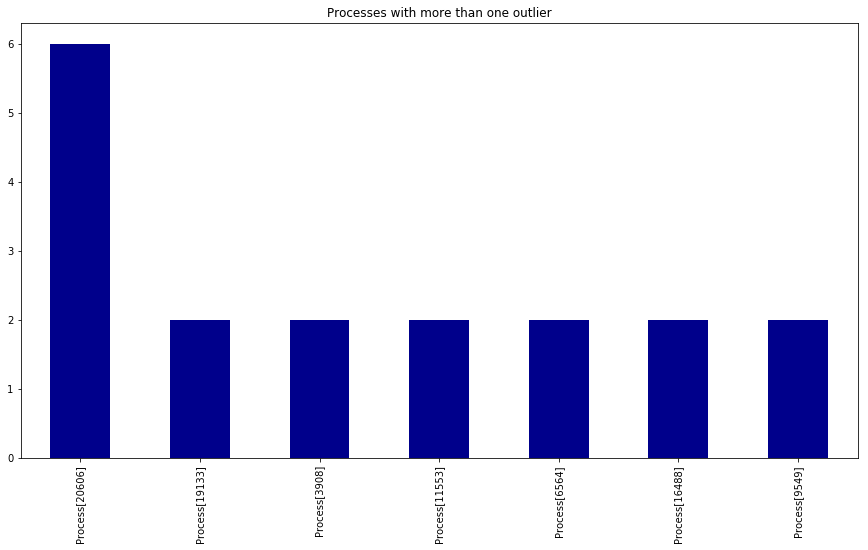

In [42]:
# Lets examine tcsh

q = Process.select(lambda p: p.job==js[0] and p.exename=="tcsh").without_distinct()
q = select(p.threads.metrics for p in q).without_distinct()
q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# order by is important as it always produces the same order of threads
meas = {}
for m in q[:]:
    if m[1] not in meas:
        meas[m[1]] = [ (m[0], m[2]) ]
    else:
        meas[m[1]].append( (m[0], m[2]) )

# Very important to be sorted by thread object here!

df = pd.DataFrame()
for k in tofind:
    if k in meas:
        v,t = zip(*meas[k])
        df[k] = v
        if 'thread' not in df.columns:
            df['thread'] = t

# TEST
#t = Thread[41211]
#print t,t.process
#print t.metrics.value
# Thread[23153] Process[20602] tcsh at 2019-02-15 18:46:10.422353 delayacct_blkio_time 10000.0
# Thread[38021] Process[33690] tcsh at 2019-02-15 18:01:31.958077 delayacct_blkio_time 2520000.0
        

outlier_dfs=[]
outlier_procs=[]
for metric in tofind:
    print
#    a = pd.DataFrame()
    b = pd.DataFrame()
    b = get_outliers(df[['thread',metric]].copy(),metric)
    print_outliers(b,metric)
    outlier_dfs.append(b)
    for index, row in b.iterrows():
            outlier_procs.append(row['thread'].process) 

#print outliers
print("Processes with more than one outlier")
dfvc = pd.DataFrame({'thread': outlier_procs})
vc = dfvc['thread'].value_counts()
vc = vc[ vc != 1]
#badboys = pd.DataFrame(columns=["key","exe","host","time","duration_us"])
for index, value in vc.iteritems():
        print(index,index.exename,"on",index.host.name,"at",index.start,"for",index.duration)
ax = vc.plot.bar(title="Processes with more than one outlier",color=['darkblue'])


newdf = df
for d in outlier_dfs:
    newdf = remove_outliers(newdf,d)

print(df.describe())
print(newdf.describe())

In [ ]:


#df = pd.DataFrame({'Duration': q[:]})
#print df.describe()
#array = [durs]
#plt.boxplot(array,showmeans=True,whis=99)
#plt.show()




In [ ]:
#    for key, value in proc_dict.iteritems():
#        if value["threads"] > value["count"]:
#            print key, value["duration"], total, value["duration"]*100.0/total 
#        names["foo"] += 1
#        attr[p.exename] += p.duration



#jobs=select(j for j in Job if j.jobid == jobid)
#for j in jobs:
#    print "Job found:",j.jobname, j.jobid

# print "TOTAL:",len(processes)
#print processes
#for p in processes:
#    print p
#processes=select((p.exename, p.duration) for p in Process if p.job == j and p.exename == "tcsh").order_by(-2)
#print "TCSH:", len(processes)
#print "SUM:",sum(p.duration for p in Process if p.job == j and p.exename == "tcsh")
# for p in processes:
#    print p[1]
# Slice up tuples into X and Y
# print labels



In [ ]:
#    
    Process.select(lambda p: p.job == jobid)
    
    j.processes w# lookup job


    doit = False
        for pat in exepatlist:
            if fnmatch.fnmatch(p.exename, pat):
                doit = True
                break
        if not doit:
            continue
total, proc_dict = get_job_processes_full_attr(jobid='19917749.moab01.princeton.rdhpcs.noaa.gov', attr_name='duration', exepatlist=["gl*"])

#print proc_dict
x_val = []
y_val = []
for key, value in proc_dict.iteritems():
    plt.plot([ i for i in range(len(value["start"]))],value["start"])
    plt.show()

print value["start"]

#threads=select(p.threads for p in Process if p.job == j)
#print "TOTAL:",len(threads)
#print j
metricnames=select(m.name for m in MetricName)[:]
#print metricnames, len(metricnames)

values=select((m.thread.process.exename, m.metricname.name, sum(m.value)) for m in Metric if m.thread.process.job == j and m.thread.process.exename == 'which').order_by(2)
#metricname == MetricName["usertime"])[:10]
#print len(values), values[:]
# foundmetricnames=[t[1] for t in values][:len(metricnames)]
# print foundmetricnames,len(foundmetricnames)
numexes = len(values)/len(metricnames)

# Iterate over metrics, using number of executables at a time
for offset in range(0,len(values),numexes):
    mn = (values[:])[offset][1]
    procnames = [p[0] for p in values[offset:offset+numexes]]
    y_val = [p[2] for p in values[offset:offset+numexes]]
    if all(i == 0.0 for i in y_val):
        print offset,mn,"had no non-zero values"
    else:
        print offset, mn
        print procnames
        print y_val
        #barplot(labels=procnames,y_val=y_val,mn=mn)

values=select((m.thread.process.pid, m.value) for m in Metric if m.metricname.name == "rssmax" and m.thread.process.exename == 'which').order_by(2)





In [ ]:
values=select((m.thread.process.exename, sum(m.thread.process.duration), m.metricname.name, sum(m.value)) for m in Metric if m.metricname.name == "systemtime" or m.metricname.name == "usertime" ).order_by(3)
print len(values)
i=len(values)/2
print i,values[0:1]
print values[64:65]
procnames = [p[0] for p in values[0:i]]
y_val1 = [p[3] for p in values[0:i]]
y_val2 = [p[3] for p in values[i:len(values)]]
barplot_stack(labels=procnames,y_val=y_val1, y2_val=y_val2,mn=["systemtime", "usertime"],yscale="linear",ylim=(0,100000000))

#

In [ ]:
print len(values[:])

In [ ]:
for p in processes:
    print count(p.threads), p.exename, p.duration
    #s um(p.threads.duration), p.threads.metrics
    threads=select (t for t in Thread if t.process == p)
    for t in threads:
            print "\t", t.tid, t.duration

In [ ]:
select((p.exename, count(p)) for p in Process if p.job == j).without_distinct()[:]
                                                                                 